## Sparse Autoencoders (experiments on MNIST)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),  # нормализация к диапазону [-1, 1]
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

Processing...
Done!


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## The simplest 1-layer encoder/decoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._l1_reg = None
        self._loss = None
        self.hidden = None  # hidden vector
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h  # save the hidden vector
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def l1_regularizer(self, size_average=True):
        """
        L1 regularizer
        """
        batch_l1_reg = torch.abs(self.hidden).sum(0)
        if size_average:
            self._l1_reg = batch_l1_reg.mean()
        else:
            self._l1_reg = batch_l1_reg.sum()
        return self._l1_reg
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs) 
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for i, model in enumerate(models.values()):
            model.optim.zero_grad()
            output = model(data)
            l1_reg_term = model.l1_regularizer()
            loss = model.loss(output, data) + alpha[i] * l1_reg_term  # * l1-regularization coefficient (alpha), for batch
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._l1_reg))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'l1 reg: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + l1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    l1_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():                
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                l1_loss[k] += m.l1_regularizer(size_average=False).item()
    
    for i, k in enumerate(models):
        test_loss[k] /= (test_size * 784)
        l1_loss[k] *= alpha[i] * (test_size // 50)    # correct by a number of batches in the test_dataset
        l1_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], l1_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], l1_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
def plot_results(model='64'):
    print("\t=================\n\t{} hidden neurons\n\t=================".format(model))
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # 1. Create and view reconstructed images
    output = models[model](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

    # 2. Create and decode from sparse encoded representation
    h_vector = torch.eye(int(model))
    print(h_vector.max(), h_vector.min())
    decoded = models[model].decode(h_vector.to(device))
    dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

    with torch.no_grad():
        encoded = models[model].E(data.view(-1, 28*28).to(device))
        print((torch.abs(encoded) > 0.5).sum(1))
        
        # 3. Fill zeros for values above the threshold
        encoded[torch.abs(encoded) < 0.5] = 0.
        decoded_f = models[model].decode(encoded)
        f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
        
    print("Reference:")
    plot_mnist(data.data.cpu().numpy(), (5, 10))
    print("Reconstructed:")
    plot_mnist(to_plot, (5, 10))
    print("Reconstructed zero-filled:")
    plot_mnist(f_to_plot, (5, 10))
    print("Decode from a sparse vector:")
    plot_mnist(dec_to_plot, (8, 8))

In [10]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
alpha = [3e-3, 3e-3, 3e-3]     # regularization coefficient

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

[model.to(device) for model in models.values()];

In [11]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.012087 32: 0.985523 64: 0.996233
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.721093 32: 0.468167 64: 0.306100
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.452868 32: 0.325378 64: 0.272918
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.340302 32: 0.278317 64: 0.233689
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.300495 32: 0.254518 64: 0.204470
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.298543 32: 0.249602 64: 0.190880
Test set:
16: loss: 0.2991	l1 reg: 0.4679
32: loss: 0.2530	l1 reg: 0.3799
64: loss: 0.1951	l1 reg: 0.3316

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.288728 32: 0.244761 64: 0.190441
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.290349 32: 0.235899 64: 0.171942
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.285983 32: 0.233572 64: 0.171918
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.269399 32: 0.211688 64: 0.149204
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.282499 32: 0.223500 64: 0.155682
Train Epoch

Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.116828 32: 0.066045 64: 0.031804
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.111676 32: 0.064890 64: 0.030528
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.115603 32: 0.063040 64: 0.030363
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.108761 32: 0.059845 64: 0.028588
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.122600 32: 0.070153 64: 0.033644
Test set:
16: loss: 0.1134	l1 reg: 0.1776
32: loss: 0.0639	l1 reg: 0.1739
64: loss: 0.0309	l1 reg: 0.1512

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.110176 32: 0.059261 64: 0.028796
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.125484 32: 0.071791 64: 0.034346
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.124156 32: 0.072814 64: 0.034066
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.114983 32: 0.061015 64: 0.028512
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.117888 32: 0.065237 64: 0.030776
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.108911 32: 0.059958 64: 0.0

	16 hidden neurons
tensor(1.) tensor(0.)
tensor([ 2,  3,  2,  2,  2,  2,  1,  0,  4,  2,  3,  3,  3,  3,
         3,  2,  1,  2,  2,  1,  2,  3,  2,  1,  1,  5,  2,  1,
         3,  2,  1,  1,  3,  2,  1,  2,  1,  2,  1,  2,  2,  1,
         3,  0,  2,  1,  2,  1,  5,  1], device='cuda:0')
Reference:


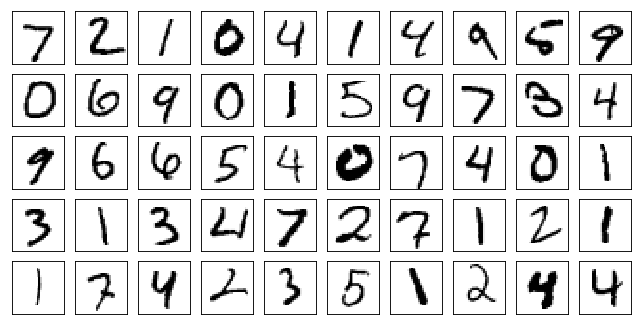

Reconstructed:


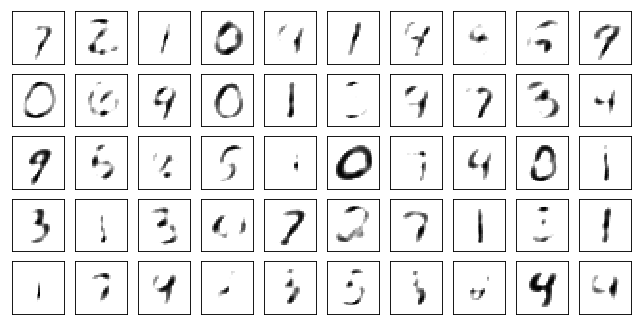

Reconstructed zero-filled:


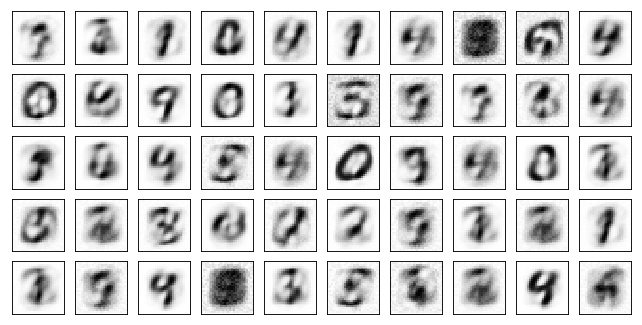

Decode from a sparse vector:


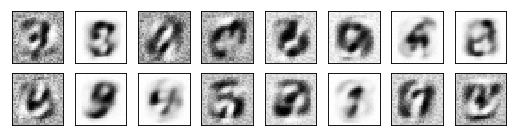

	32 hidden neurons
tensor(1.) tensor(0.)
tensor([ 5,  5,  3,  5,  3,  3,  7,  2,  4,  3,  6,  5,  4,  6,
         5,  5,  2,  4,  7,  2,  3,  5,  3,  2,  1,  6,  3,  1,
         5,  6,  4,  2,  5,  4,  6,  5,  2,  6,  1,  2,  2,  1,
         3,  3,  3,  2,  4,  2,  4,  2], device='cuda:0')
Reference:


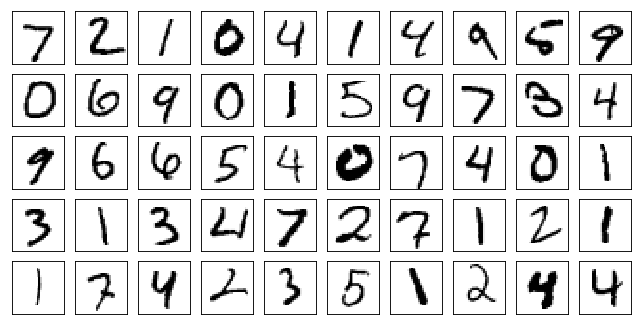

Reconstructed:


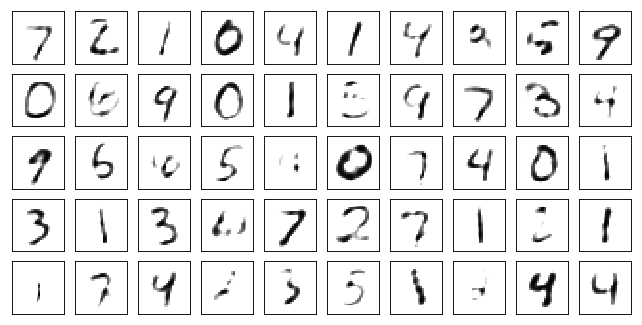

Reconstructed zero-filled:


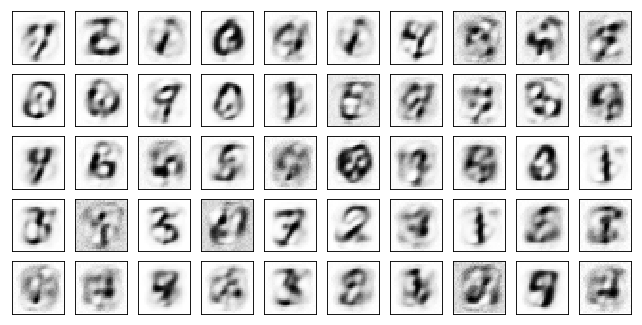

Decode from a sparse vector:


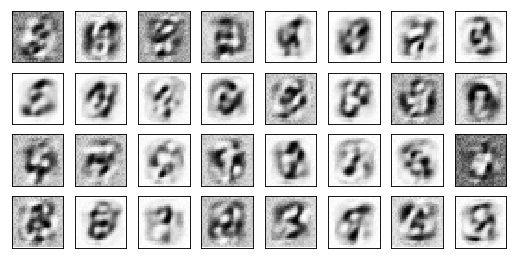

	64 hidden neurons
tensor(1.) tensor(0.)
tensor([  3,   8,   4,   5,   4,   4,   4,   5,   6,   5,   3,   7,
          4,   6,   4,   5,   4,   6,   9,   2,   3,   2,   4,   6,
          2,  10,   3,   5,   5,   5,   4,   2,   3,   4,   4,   8,
          4,   5,   6,   5,   3,   2,   3,   5,   4,   1,   5,   4,
          5,   6], device='cuda:0')
Reference:


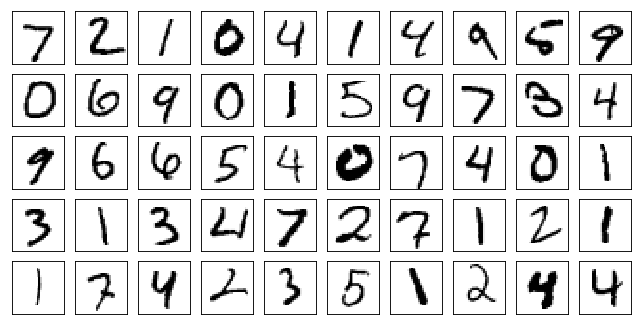

Reconstructed:


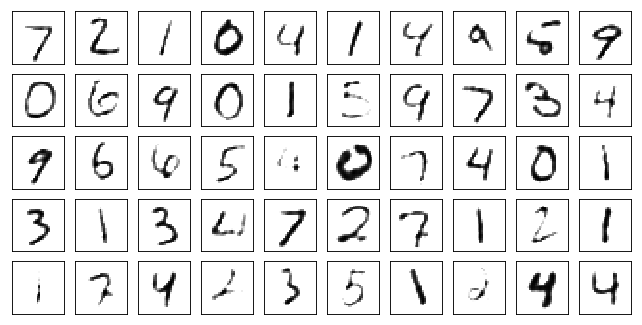

Reconstructed zero-filled:


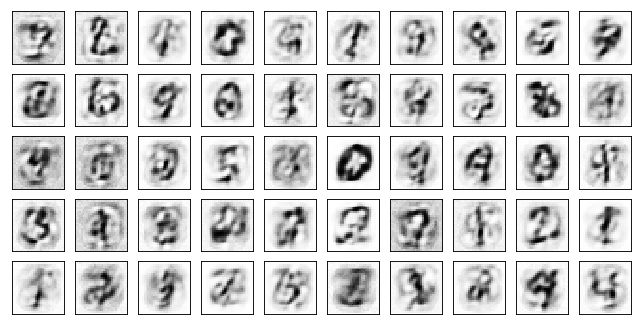

Decode from a sparse vector:


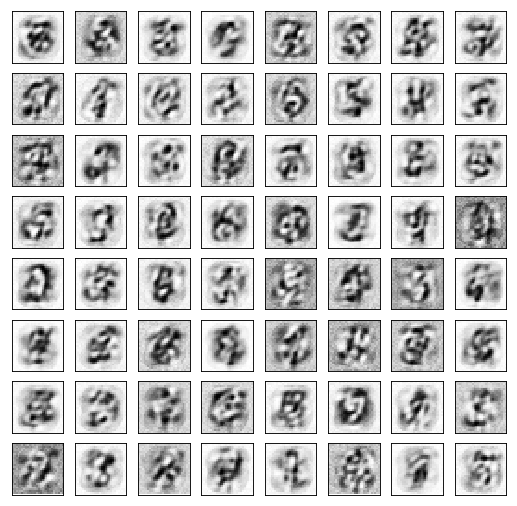

In [12]:
plot_results('16')
plot_results('32')
plot_results('64')

## Construct 2-layer network

In [32]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [33]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._l1_reg = None
        self._loss = None
        self.hidden = None  # hidden vector
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h  # save the hidden vector
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def l1_regularizer(self, size_average=True):
        """
        L1 regularizer
        """
        batch_l1_reg = torch.abs(self.hidden).sum(0)
        if size_average:
            self._l1_reg = batch_l1_reg.mean()
        else:
            self._l1_reg = batch_l1_reg.sum()
        return self._l1_reg
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs) 
        return self._loss

In [34]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
# alpha = [3e-4, 3e-3, 8e-3]     # regularization coefficient
alpha = [3e-3, 3e-3, 3e-3]     # regularization coefficient

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

[model.to(device) for model in models.values()];

In [35]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.938549 32: 0.945637 64: 0.937437
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.411697 32: 0.319296 64: 0.290821
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.275512 32: 0.260626 64: 0.250220
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.278193 32: 0.261987 64: 0.245188
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.259317 32: 0.243070 64: 0.226514
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.254885 32: 0.240339 64: 0.214820
Test set:
16: loss: 0.2575	l1 reg: 0.1168
32: loss: 0.2407	l1 reg: 0.0887
64: loss: 0.2135	l1 reg: 0.0737

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.254751 32: 0.239845 64: 0.212548
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.244429 32: 0.229869 64: 0.196945
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.225498 32: 0.210888 64: 0.176521
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.234118 32: 0.215632 64: 0.180164
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.220990 32: 0.203369 64: 0.171161
Train Epoch

Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.140474 32: 0.104741 64: 0.073209
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.147671 32: 0.113171 64: 0.078058
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.143129 32: 0.101857 64: 0.067048
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.134157 32: 0.102895 64: 0.069523
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.129552 32: 0.098756 64: 0.070671
Test set:
16: loss: 0.1403	l1 reg: 0.0464
32: loss: 0.1050	l1 reg: 0.0523
64: loss: 0.0727	l1 reg: 0.0615

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.132015 32: 0.096486 64: 0.066444
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.144764 32: 0.107192 64: 0.072165
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.138609 32: 0.106121 64: 0.072546
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.156427 32: 0.118949 64: 0.080515
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.135621 32: 0.102864 64: 0.069365
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.157914 32: 0.123113 64: 0.0

	16 hidden neurons
tensor(1.) tensor(0.)
tensor([ 0,  0,  2,  0,  0,  2,  0,  0,  0,  0,  1,  0,  0,  0,
         2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  1,  0,  0,  0,  0,  0,  2,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Reference:


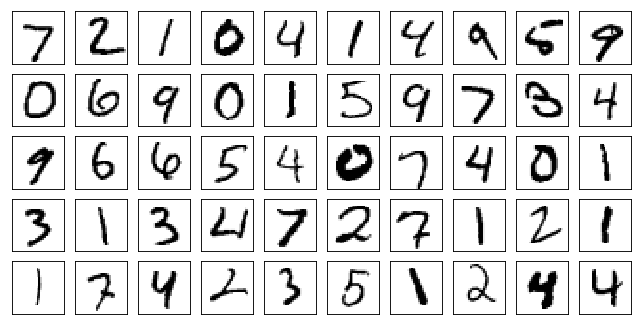

Reconstructed:


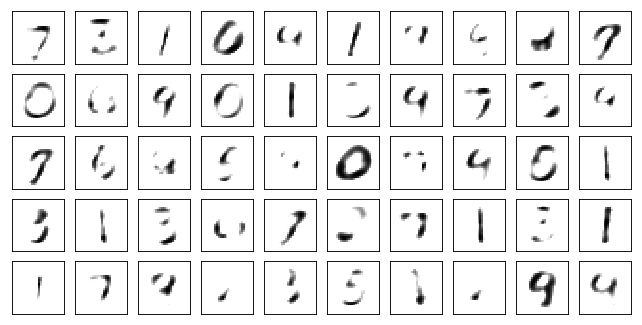

Reconstructed zero-filled:


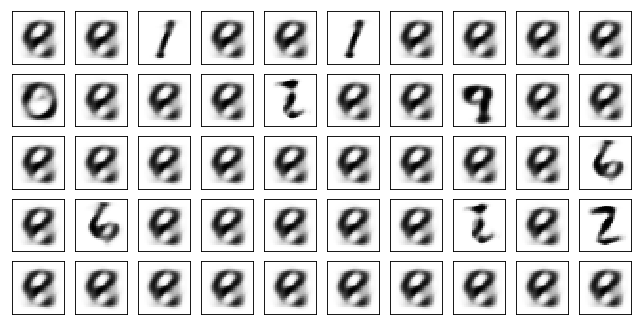

Decode from a sparse vector:


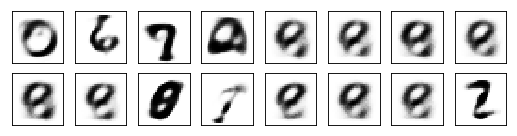

	32 hidden neurons
tensor(1.) tensor(0.)
tensor([ 1,  0,  1,  2,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,
         2,  1,  0,  1,  0,  0,  1,  3,  1,  1,  0,  2,  1,  0,
         0,  2,  0,  2,  1,  0,  2,  1,  1,  2,  0,  1,  1,  0,
         3,  0,  0,  0,  2,  0,  1,  0], device='cuda:0')
Reference:


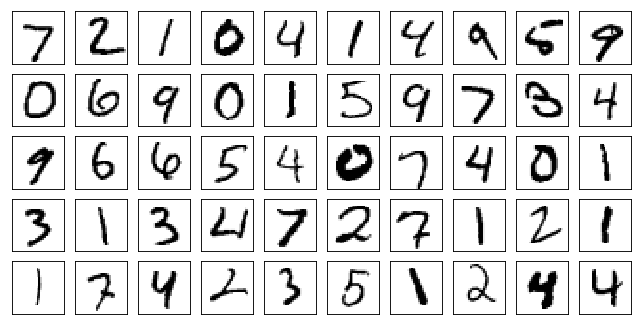

Reconstructed:


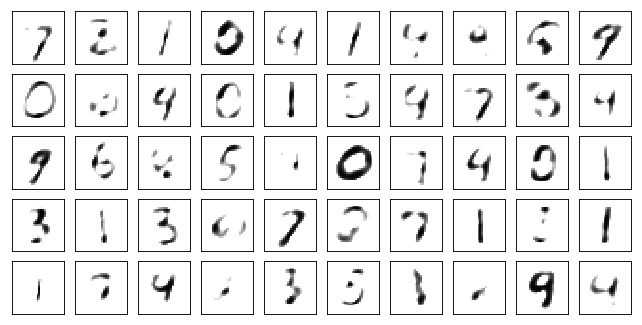

Reconstructed zero-filled:


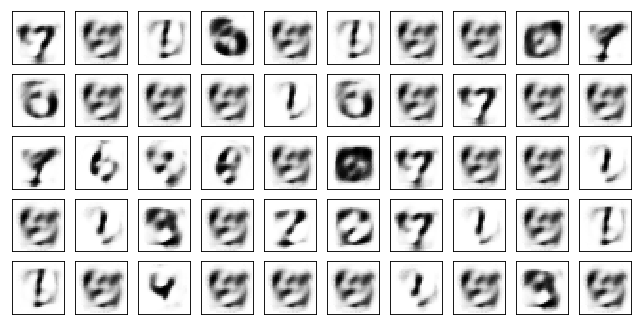

Decode from a sparse vector:


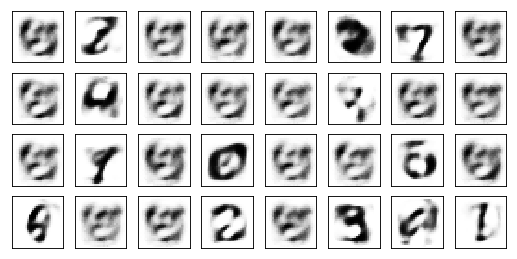

	64 hidden neurons
tensor(1.) tensor(0.)
tensor([ 3,  3,  2,  5,  4,  2,  2,  2,  2,  6,  7,  2,  2,  5,
         3,  2,  6,  4,  2,  2,  3,  5,  5,  3,  1,  5,  4,  4,
         4,  3,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         4,  0,  3,  1,  4,  2,  5,  3], device='cuda:0')
Reference:


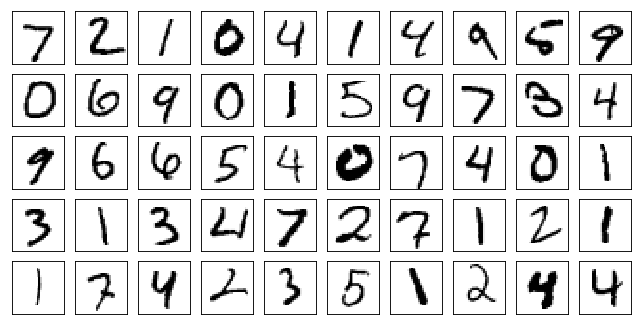

Reconstructed:


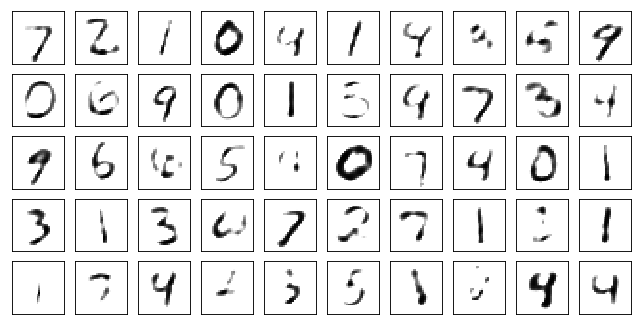

Reconstructed zero-filled:


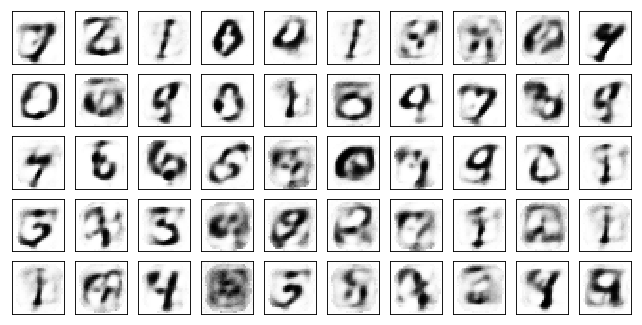

Decode from a sparse vector:


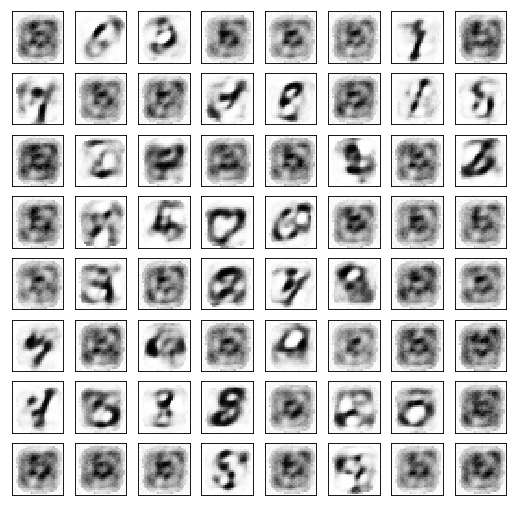

In [36]:
plot_results('16')
plot_results('32')
plot_results('64')

С двуслойными кодировщиком и декодером удалось подобрать коэфф. L1 регуляризации для модели с 64 нейронами в скрытом слое 